# Question 1 

CIFAR10 is a public dataset of color images. Please design a Convolutional Neural Network to predict labels of the images. Codes for data preprocessing are given. (50%)

In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms as transforms # import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data processing
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=False, transform=transform) # Already downloaded the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=False, transform=transform) # Already downloaded the dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# Check the number of batches in the train loader and test loader, respectively
print(len(trainloader))
print(len(testloader))

12500
2500


truck  deer  bird plane


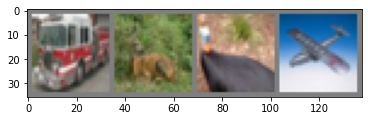

In [4]:
# Show some images in the training set
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))

# Show labels
print(" ".join('%5s'%classes[labels[j]] for j in range(4)))

In [5]:
# Define the Convolutional Neural Network (CNN) model (25%)
# Please define your CNN here. 

# Design your own model or follow my suggestions:
# Hints: color image contains 3 channels (R, G, and B), 
#        so dimensionality of each data sample is (3, 32, 32)

# Suggestions for CNN design (There is no need to follow my suggestion):
# 1. Convolution layer 1: 5*5 filter, 6 output channels, stride 1, 2*2 max pooling
# 2. Convolution layer 2: 5*5 filter, 16 output channels, stride 1, 2*2 max pooling
# 3. Fully connect layer 1: 16*8*8 (output_size of your convolution layer 2 == feature_num) -> 120 (hidden_dim)
# 4. Fully connect layer 2: 120 -> 84 (output_dim_1)
# 5. Fully connect layer 3: 84 -> 10 (output_dim_2)

class Net(nn.Module):
   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         # First convolution; input shape (3, 32, 32) = (C, H, W)
                                            # nn.Sequential -> 1. nn.Cov2d; 2. nn.ReLU; 3. nn.MaxPool2d
            nn.Conv2d(
                in_channels=3,              # Number of input channels, for color image set as 3
                out_channels=6,             # Number of filters/feature maps/output channels
                kernel_size=5,              # Filter size 5*5
                stride=1,                   # Filter movement/step
                padding=2,                  # If we want the output to have the same width and length as the input image shape (3, 32, 32)
                                            # after Conv2d, we set padding=(kernel_size - 1)/2 if stride=1
                                            # So, padding = (5 - 1)/2 = 2
            ),                              # Output shape (6, 32, 32) after Conv2d
            nn.ReLU(),                      # Use ReLU as non-linear activation
            nn.MaxPool2d(kernel_size=2),    # Choose max value in 2x2 pooling area, so the output shape is (6, 16, 16); 16 = 32/2
        )
        self.conv2 = nn.Sequential(         # Second convolution; input shape (6, 16, 16)
            nn.Conv2d(
                in_channels=6,              # Number of input channels
                out_channels=16,            # Number of filters/feature maps/output channels
                kernel_size=5, 
                stride=1, 
                padding=2,
            ),                              # Output shape (16, 16, 16) after Conv2d
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    # Choose max value in 2x2 pooling area, so the output shape is (16, 8, 8); 8 = 16/2
        )
        self.fc1 = torch.nn.Linear(16*8*8, 120) # Fully connect layer 1: 16*8*8 (output_size of your convolution layer 2) -> 120 (hidden_dim)
        self.fc2 = torch.nn.Linear(120, 84)     # Fully connect layer 2: 120 -> 84 (output_dim_1)
        self.fc3 = torch.nn.Linear(84, 10)      # Fully connect layer 3: 84 -> 10 (output_dim_2)

    def forward(self, x):
        x = self.conv1(x)                   # Flow (batch_size, 3, 32, 32) into conv1 and get (batch_size, 6, 16, 16)
        x = self.conv2(x)                   # Flow (batch_size, 6, 16, 16) into conv2 and get (batch_size, 16, 8, 8)
        x = x.view(-1, 16*8*8)              # Flatten the output of 2nd Conv2d to (batch_size, 16*8*8)
        x = self.fc1(x)                     # Flow (batch_size, 16*8*8) into fc1 and get (batch_size, 120)
        x = F.relu(x)                       # max(0, x); introduce non-linearies into the model
        x = self.fc2(x)                     # Flow (batch_size, 120) into fc2 and get (batch_size, 84)
        x = F.relu(x)                       # max(0, x); introduce non-linearies into the model
        x = self.fc3(x)                     # Flow (batch_size, 84) into fc2 and get (batch_size, 10)
        return x                            # return x for visualization

net = Net()

In [6]:
# Take a look at net architecture
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
# Train your model: (15%)
# Define hyper-parameters
EPOCH = 3   # Train the training data n times, to save time, we just train 3 epoches
LR = 0.001  # Learning rate

# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LR) # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define loss function
loss_func = nn.CrossEntropyLoss() 

# Training CNN
# We loop over our train data iterator, and flow the inputs to the network and optimize it.
loss_history = []
train_history = []
val_history = []
    
for epoch in range(EPOCH): # Loop from 0 to 2 epochs; each epoch contains the shuffled entire training set
    
    print('Running epoch %s' % epoch)
    
    running_loss = 0.0
    running_corrects = 0
    
    for step, (features, labels) in enumerate(trainloader): # Loop from each batch of input features and labels from trainloader during one epoch

        optimizer.zero_grad()              # Zero the parameter gradients
        output = net(features)             # Forward: network output
        loss = loss_func(output, labels)   # Forward: calculate cross entropy loss
        loss.backward()                    # Backward: compute gradients
        optimizer.step()                   # Optimize: apply gradients to update the model's weights
        
        running_loss += loss.item()        # Add loss statistics per batch of input features and labels 
        if step % 2000 == 1999:            # Print average loss per 2000 mini-batches; 1999 % 2000 = 1999
            print(f'[{epoch + 1}, {step + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Running epoch 0
[1,  2000] loss: 1.809
[1,  4000] loss: 1.546
[1,  6000] loss: 1.431
[1,  8000] loss: 1.354
[1, 10000] loss: 1.319
[1, 12000] loss: 1.261
Running epoch 1
[2,  2000] loss: 1.166
[2,  4000] loss: 1.152
[2,  6000] loss: 1.141
[2,  8000] loss: 1.141
[2, 10000] loss: 1.136
[2, 12000] loss: 1.121
Running epoch 2
[3,  2000] loss: 1.032
[3,  4000] loss: 1.021
[3,  6000] loss: 1.027
[3,  8000] loss: 1.029
[3, 10000] loss: 1.027
[3, 12000] loss: 1.023
Finished Training


In [8]:
# Save our model parameters
torch.save(net.state_dict(), 'CNN_params.pkl')

GroundTruth:  cat   ship  ship  plane


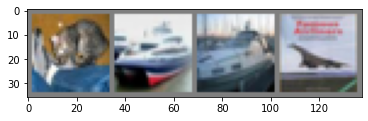

In [9]:
# Test your model: (10%)
# Check how the CNN performs on the examples
# Display an image from the test set
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
# Reload our saved model's parameters
net = Net()
net.load_state_dict(torch.load('CNN_params.pkl'))

<All keys matched successfully>

In [11]:
# Make predictions on the above 4 examples using our model
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  plane plane


In [12]:
# Check how our model performs on the whole dataset
# Initialize the empty correct and total value
correct = 0
total = 0
with torch.no_grad(): # Do not calculate the gradients
    for data in testloader:
        features, labels = data # Divide each piece of data in testloader into two parts: features and labels
        outputs = net(features) # Feed features/images into our convolutional neural network
        _, predicted = torch.max(outputs.data, 1) # Class with the highest energy is choosen as the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Output accuracy for the whole test set
print('Accuracy of our model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of our model on the 10000 test images: 61 %


In [13]:
# Where does 10000 come from? Number of batches in the testloader * number of examples in one batch (4 images)
len(testloader) * 4

10000

In [14]:
# Check how the CNN performs for each class
# Initilize an empty dictionary for recording the correct predictions for each class
correct_pred = {classname: 0 for classname in classes}
# Initilize an empty dictionary for recording the total predictions for each class
total_pred = {classname: 0 for classname in classes}

with torch.no_grad(): # Do not calculate the gradients
    for data in testloader:
        features, labels = data # Divide each piece of data in testloader into two parts: features and labels
        outputs = net(features) # Feed features/images into our convolutional neural network
        _, predictions = torch.max(outputs, 1) # Class with the highest energy is choosen as the predicted class
        # Record the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
# Output accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.2 %
Accuracy for class: car   is 60.2 %
Accuracy for class: bird  is 43.4 %
Accuracy for class: cat   is 58.8 %
Accuracy for class: deer  is 55.2 %
Accuracy for class: dog   is 43.4 %
Accuracy for class: frog  is 65.3 %
Accuracy for class: horse is 73.3 %
Accuracy for class: ship  is 70.1 %
Accuracy for class: truck is 76.5 %
